In [12]:
# Gender Classification using Character Embeddings

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.base import BaseEstimator, TransformerMixin

# Custom transformer for preprocessing
class NamePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, tokenizer, max_sequence_length):
        self.tokenizer = tokenizer
        self.max_sequence_length = max_sequence_length

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_seq = self.tokenizer.texts_to_sequences(X)
        X_pad = pad_sequences(X_seq, maxlen=self.max_sequence_length, padding='post')
        return X_pad

# Load and preprocess the data
file_path = '..\\data\\mm_names.csv'
data = pd.read_csv(file_path)

# Select relevant columns
names = data['Name'].astype(str)
genders = data['Gender']

# Encode the labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(genders)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(names, labels, test_size=0.2, random_state=42)

# Tokenize the names
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences
max_sequence_length = max([len(seq) for seq in X_train_seq])
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post')

# Build the model
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 50

model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length),
    # Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=10, validation_data=(X_test_pad, y_test), batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Predict gender for a given name
class GenderPredictionPipeline:
    def __init__(self, model, tokenizer, max_sequence_length, label_encoder):
        self.model = model
        self.tokenizer = tokenizer
        self.max_sequence_length = max_sequence_length
        self.label_encoder = label_encoder

    def predict(self, name):
        name_seq = self.tokenizer.texts_to_sequences([name])
        name_pad = pad_sequences(name_seq, maxlen=self.max_sequence_length, padding='post')
        prediction = self.model.predict(name_pad)
        return (prediction > 0.5).astype(int).flatten()[0]

# Create the prediction pipeline
pipeline = GenderPredictionPipeline(model, tokenizer, max_sequence_length, label_encoder)

# Predict the gender of a given name
name = "Than Zaw Toe"  # Replace with the name you want to predict
y_pred = pipeline.predict(name)
gender = label_encoder.inverse_transform([y_pred])[0]

print("Predicted gender:", gender)


Epoch 1/10


c:\Users\thanz\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


134/134 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6090 - loss: 0.6350 - val_accuracy: 0.7249 - val_loss: 0.5360
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.7145 - loss: 0.5432 - val_accuracy: 0.7089 - val_loss: 0.5423
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7545 - loss: 0.5135 - val_accuracy: 0.7521 - val_loss: 0.4894
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7615 - loss: 0.4802 - val_accuracy: 0.7606 - val_loss: 0.4536
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.7689 - loss: 0.4665 - val_accuracy: 0.7803 - val_loss: 0.4347
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8013 - loss: 0.4229 - val_accuracy: 0.7906 - val_loss: 0.4247
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7870 - loss: 0.4276 - val_accuracy: 0.7934 - val_loss: 0.4177
Epoch 8/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8036 - loss: 0.4120 - val_accuracy: 0.800

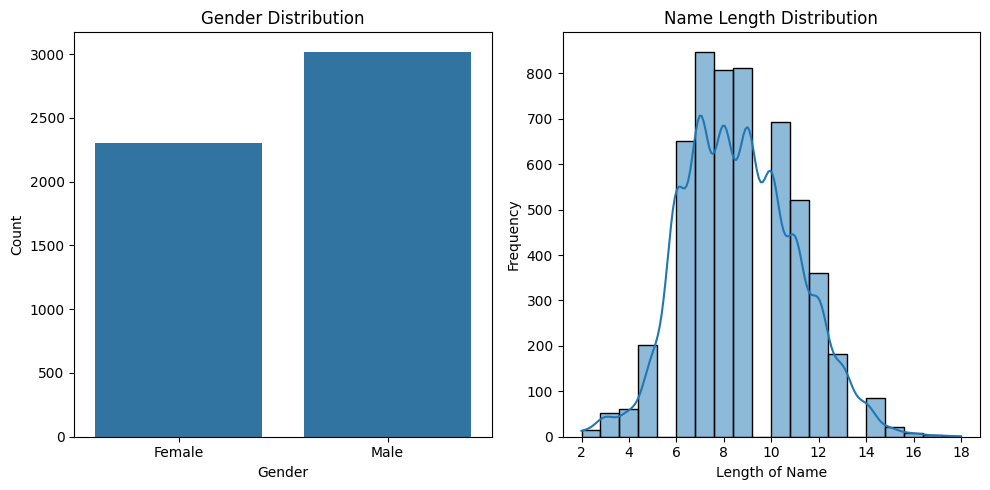

In [13]:
# Demographic visualizations
plt.figure(figsize=(10, 5))

# Gender distribution
plt.subplot(1, 2, 1)
sns.countplot(x=genders)
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')

# Length of names distribution
name_lengths = names.apply(len)
plt.subplot(1, 2, 2)
sns.histplot(name_lengths, bins=20, kde=True)
plt.title('Name Length Distribution')
plt.xlabel('Length of Name')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


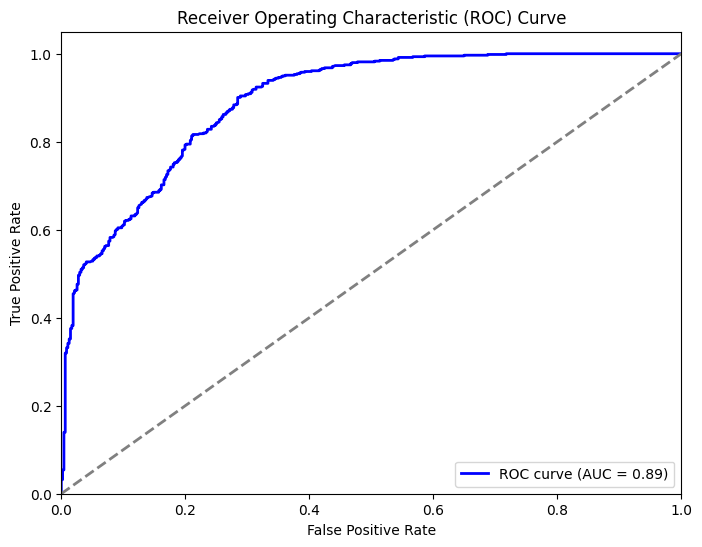

In [14]:
# Predict probabilities for the test set
y_pred_prob = model.predict(X_test_pad).flatten()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()